In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from tqdm import tqdm

In [53]:
import cv2
import glob
import matplotlib.pyplot as plt
import json
import pprint
import os
from damage_detection_functions import *
%matplotlib inline

In [7]:
json_filenames = sorted(glob.glob("C:/Users/thoma/OneDrive/Damage Detection/train/labels/*"))
filenames = sorted(glob.glob("C:/Users/thoma/OneDrive/Damage Detection/train/images/*"))


In [9]:
dataset = {}
for i in tqdm(range(len(filenames))):
  dataset[filenames[i]] = {}
  json_filename = json_filenames[i]
  with open(json_filename) as json_file:
    data = json.load(json_file)
  dataset[filenames[i]]["damage_type"] = data["metadata"]["disaster_type"]
  dataset[filenames[i]]["building_list"] = []
  building_index = 0
  for building in data["features"]["xy"]:
    dataset[filenames[i]]["building_list"].append({})
    dataset[filenames[i]]["building_list"][building_index]["UID"] = building["properties"]["uid"]
    if "subtype" in building["properties"].keys():
      dataset[filenames[i]]["building_list"][building_index]["damage_level"] = building["properties"]["subtype"]
    polygon = convert_format_to_tuple_of_coords(building['wkt'])
    xmin = polygon[0][0]
    xmax = polygon[0][0]
    ymin = polygon[0][1]
    ymax = polygon[0][1]
    for (x,y) in polygon:
      xmin = min(x, xmin)
      ymin = min(y, ymin)
      xmax = max(x, xmax)
      ymax = max(y, ymax)
    dataset[filenames[i]]["building_list"][building_index]["bbox"] = [xmin, ymin, xmax - xmin, ymax - ymin]
    building_index += 1

100%|██████████████████████████████████████████████████████████████████████████████| 5598/5598 [00:58<00:00, 95.87it/s]


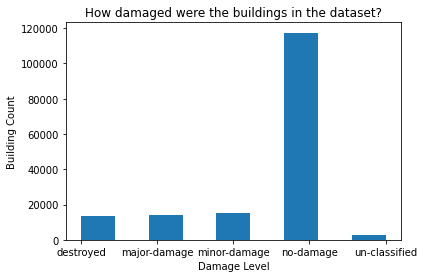

{'no-damage': 117426, 'minor-damage': 14980, 'destroyed': 13227, 'major-damage': 14161, 'un-classified': 2993}


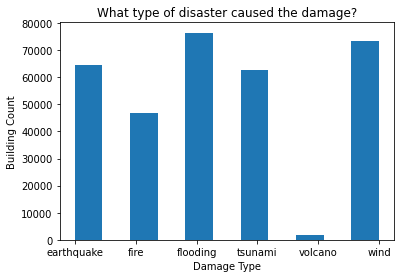

{'volcano': 1712, 'flooding': 76432, 'wind': 73250, 'earthquake': 64542, 'tsunami': 62788, 'fire': 46850}


In [10]:
show_damage_level_frequency_in_dataset(dataset)
show_damage_type_frequency_in_dataset(dataset)

In [32]:
print(list(dataset.keys())[:5])

['C:/Users/thoma/OneDrive/Damage Detection/train/images\\guatemala-volcano_00000000_post_disaster.png', 'C:/Users/thoma/OneDrive/Damage Detection/train/images\\guatemala-volcano_00000000_pre_disaster.png', 'C:/Users/thoma/OneDrive/Damage Detection/train/images\\guatemala-volcano_00000001_post_disaster.png', 'C:/Users/thoma/OneDrive/Damage Detection/train/images\\guatemala-volcano_00000001_pre_disaster.png', 'C:/Users/thoma/OneDrive/Damage Detection/train/images\\guatemala-volcano_00000002_post_disaster.png']


9


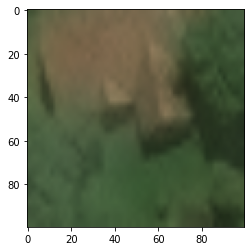

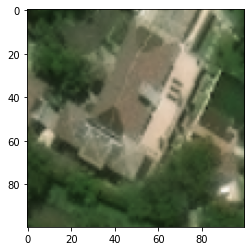

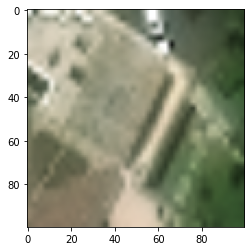

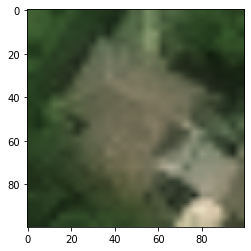

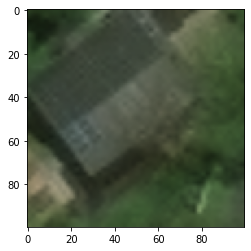

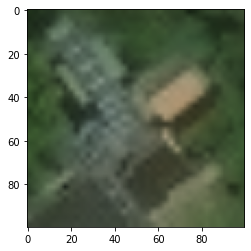

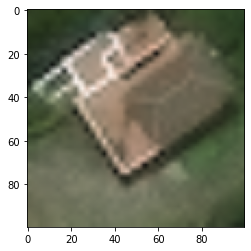

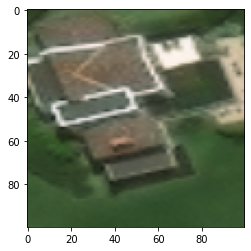

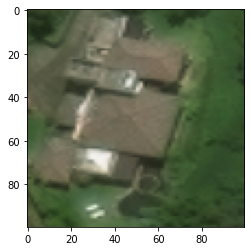

9


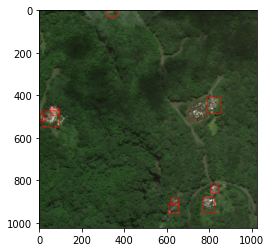

In [18]:
im = 'C:/Users/thoma/OneDrive/Damage Detection/train/images\\guatemala-volcano_00000007_post_disaster.png'
show_building_crops_from_image_filename(dataset, im)
show_bounding_boxes_from_image_filename(dataset, im)


In [116]:
train_pics, val_pics = split_dataset_post_disaster(dataset)
for pic in sorted(list(val_pics.keys()))[:10]:
    print(pic[54:-4])

guatemala-volcano_00000002_post_disaster
guatemala-volcano_00000017_post_disaster
guatemala-volcano_00000019_post_disaster
hurricane-florence_00000012_post_disaster
hurricane-florence_00000020_post_disaster
hurricane-florence_00000044_post_disaster
hurricane-florence_00000058_post_disaster
hurricane-florence_00000062_post_disaster
hurricane-florence_00000084_post_disaster
hurricane-florence_00000093_post_disaster


In [118]:
#put train crops in category folders
for pic in tqdm(train_pics):
    image = cv2.imread(pic)[:,:,::-1].astype("uint8")
    building_index = -1
    for building in dataset[pic]['building_list']:
        building_index += 1
        bbox = get_expanded_bounding_box(building['bbox'], image)
        x = bbox[0]
        y = bbox[1]
        width = bbox[2]
        height = bbox[3]
        crop = image[int(y):int(y+height), int(x):int(x+width), :]
        resized_crop = cv2.resize(crop, (100,100), cv2.INTER_LINEAR)
        dl = building['damage_level']
        if dl == 'unclassified':
            continue
        elif dl == 'destroyed':
            path = 'C:/Users/thoma/OneDrive/Damage Detection/trainandval/train/destroyed'
        elif dl == 'major-damage':
            path = 'C:/Users/thoma/OneDrive/Damage Detection/trainandval/train/major_damage'
        elif dl == 'minor-damage':
            path = 'C:/Users/thoma/OneDrive/Damage Detection/trainandval/train/minor_damage'
        elif dl == 'no-damage':
            path = 'C:/Users/thoma/OneDrive/Damage Detection/trainandval/train/no_damage'
        im_filename = pic[54:-4] + "_building_" + str(building_index).zfill(5) + '.png'
        cv2.imwrite(os.path.join(path, im_filename), resized_crop)
        cv2.waitKey(0)

100%|██████████████████████████████████████████████████████████████████████████████| 2240/2240 [06:34<00:00,  2.40it/s]


In [117]:
#put val crops in category folders
for pic in tqdm(val_pics):
    image = cv2.imread(pic)[:,:,::-1].astype("uint8")
    building_index = -1
    for building in dataset[pic]['building_list']:
        building_index += 1
        bbox = get_expanded_bounding_box(building['bbox'], image)
        x = bbox[0]
        y = bbox[1]
        width = bbox[2]
        height = bbox[3]
        crop = image[int(y):int(y+height), int(x):int(x+width), :]
        resized_crop = cv2.resize(crop, (100,100), cv2.INTER_LINEAR)
        dl = building['damage_level']
        if dl == 'unclassified':
            continue
        elif dl == 'destroyed':
            path = 'C:/Users/thoma/OneDrive/Damage Detection/trainandval/val/destroyed'
        elif dl == 'major-damage':
            path = 'C:/Users/thoma/OneDrive/Damage Detection/trainandval/val/major_damage'
        elif dl == 'minor-damage':
            path = 'C:/Users/thoma/OneDrive/Damage Detection/trainandval/val/minor_damage'
        elif dl == 'no-damage':
            path = 'C:/Users/thoma/OneDrive/Damage Detection/trainandval/val/no_damage'
        im_filename = pic[54:-4] + "_building_" + str(building_index).zfill(5) + '.png'
        cv2.imwrite(os.path.join(path, im_filename), resized_crop)
        cv2.waitKey(0)

100%|████████████████████████████████████████████████████████████████████████████████| 559/559 [01:34<00:00,  7.91it/s]


In [42]:
print("100".zfill(4))

0100


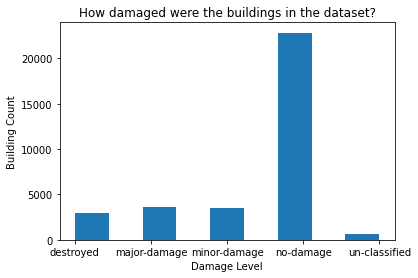

{'un-classified': 587, 'destroyed': 2994, 'no-damage': 22820, 'minor-damage': 3490, 'major-damage': 3601}


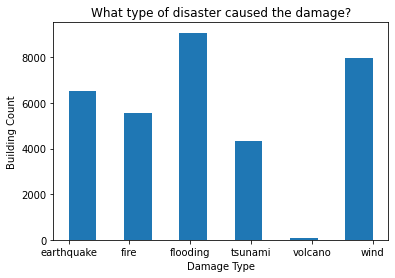

{'fire': 5541, 'tsunami': 4314, 'wind': 7979, 'flooding': 9073, 'earthquake': 6504, 'volcano': 81}


In [120]:
show_damage_level_frequency_in_dataset(val_pics)
show_damage_type_frequency_in_dataset(val_pics)